In [1]:
from pathlib import Path
import numpy as np
import transformers
import zarr
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchaudio
import multiprocessing as mp
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
import time

In [6]:
root_dir = Path.cwd()

unpacked_data_train_dir = root_dir / "data" / "common_voice" / "unpacked_data_train"
unpacked_data_dev_dir = root_dir / "data" / "common_voice" / "unpacked_data_dev"

train_csv_path = root_dir / "data" / "common_voice" / "train.tsv"
test_csv_path = root_dir / "data" / "common_voice" / "test.tsv"
dev_csv_path = root_dir / "data" / "common_voice" / "dev.tsv"

zarr_archive_path = root_dir / "data" / "preprocessed" / "train_full_v5.zarr"

zarr_archive_path.parent.mkdir(exist_ok=True, parents=True)


train_df = pd.read_csv(train_csv_path, delimiter="\t")
test_df = pd.read_csv(test_csv_path, delimiter="\t")
dev_df = pd.read_csv(dev_csv_path, delimiter="\t")

print(f"Number train samples:\t{train_df.shape[0]}")
print(f"Number test samples:\t{test_df.shape[0]}")
print(f"Number dev samples:\t{dev_df.shape[0]}")

/tmp/ipykernel_26169/213021828.py:15: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_csv_path, delimiter="\t")


Number train samples:	1100826
Number test samples:	16393
Number dev samples:	16392


In [7]:
def filter_df(
    df,
    max_down_votes: int,
    min_up_votes: int,
    min_number_tracks_per_client: int,
    max_number_tracks_per_client: int,
):

    df = df[(df.up_votes >= min_up_votes) & (df.down_votes <= max_down_votes)]

    print(f"Number of filtered audio samples after vote filtering:\t{df.shape[0]}")
    print(f"Number of clients after vote filtering:\t{len(df.client_id.unique())}")

    clients_df = df.groupby("client_id").path.count().reset_index()

    clients_df = clients_df[
        (clients_df.path >= min_number_tracks_per_client)
        & (clients_df.path <= max_number_tracks_per_client)
    ]

    df = df[df.client_id.isin(clients_df.client_id)]

    print(
        f"Number of filtered audio samples after track count filtering:\t{df.shape[0]}"
    )
    print(
        f"Number of clients after track count filtering:\t{len(df.client_id.unique())}"
    )

    return df


max_down_votes = 0
min_up_votes = 2
max_number_tracks_per_client = 1000
min_number_tracks_per_client = 100

df_train_filtered = filter_df(
    train_df.copy(),
    max_down_votes=max_down_votes,
    min_up_votes=min_up_votes,
    max_number_tracks_per_client=max_number_tracks_per_client,
    min_number_tracks_per_client=min_number_tracks_per_client,
)

Number of filtered audio samples after vote filtering:	938005
Number of clients after vote filtering:	36939
Number of filtered audio samples after track count filtering:	305706
Number of clients after track count filtering:	1257


In [8]:
audio_path_mapping = {x.name: x for x in unpacked_data_train_dir.rglob("*.mp3")}

In [9]:
feature_size = 80
chunk_length = 30
hop_length = 160
target_sample_rate = 16000
feature_extractor = transformers.WhisperFeatureExtractor(
    feature_size=feature_size,
    chunk_length=chunk_length,
    hop_length=hop_length,
    device="cuda",
)

In [10]:
## Extract Features from audio files for machine learning model to train on and save them in a zarr archive
age_mapping = {
    "twenties": 20,
    "thirties": 30,
    "fifties": 50,
    "fourties": 40,
    "teens": 10,
    "sixties": 60,
    "seventies": 70,
    "eighties": 80,
    "nineties": 90,
}
batch_size = 128
num_workers = 4

zarr_root = zarr.open(zarr_archive_path, mode="w")

df = df_train_filtered

zarr_root.create_array(
    "features",
    shape=(
        df.shape[0],
        feature_size,
        int(target_sample_rate / hop_length * chunk_length) // 3,
    ),
    chunks=(1, feature_size, int(target_sample_rate / hop_length * chunk_length) // 3),
    dtype="float32",
)

zarr_root.create_array(
    "attention_mask",
    shape=(
        df.shape[0],
        int(target_sample_rate / hop_length * chunk_length) // 3,
    ),
    chunks=(1, int(target_sample_rate / hop_length * chunk_length) // 3),
    dtype="int32",
)

zarr_root.create_array(
    "client_index",
    shape=(df.shape[0],),
    dtype="int32",
)

zarr_root.create_array(
    "gender",
    shape=(df.shape[0],),
    dtype="uint8",
)

zarr_root.create_array(
    "age",
    shape=(df.shape[0],),
    dtype="uint8",
)

zarr_root.create_array(
    "client_id",
    shape=(df.shape[0],),
    dtype=f"S{len(df.iloc[0])}",
)

zarr_root.create_array(
    "path",
    shape=(df.shape[0],),
    dtype=f"S32",
)

client_indices = {
    v: k
    for k, v in df.groupby("client_id")
    .count()
    .reset_index()[["client_id"]]
    .to_dict()["client_id"]
    .items()
}

time_pre = []
time_feature = []
time_after = []


def process_batch(batch_inputs):
    batch_idx, batch = batch_inputs

    audio_16k = []
    row_indices = []
    batch_client_ids = []
    batch_age_numbers = []
    batch_genders = []
    client_ids = []
    paths = []

    time_pre_start = time.time()

    for row_index, (index, row) in enumerate(batch.iterrows()):
        audio_path = audio_path_mapping.get(row.path)

        # row_index += batch_idx * batch_size
        row_index = index

        row_indices.append(index)

        if not audio_path:
            print(f"Missing audio file:\t{row.path}")
            continue

        audio, orig_sr = torchaudio.load(audio_path)

        audio_16k.append(
            torchaudio.functional.resample(
                audio, orig_freq=orig_sr, new_freq=target_sample_rate
            )[0, :]
        )

        batch_client_ids.append(row.client_id)
        batch_age_numbers.append(age_mapping.get(row.get("age", 255), 255))

        gender = row.get("gender", np.nan)

        if gender == "male_masculine":
            gender_number = 1
        elif gender == "female_feminine":
            gender_number = 2
        else:
            gender_number = 255
        batch_genders.append(gender_number)

        client_ids.append(row.client_id.encode("utf-8"))
        paths.append(row.path.ljust(32).encode("utf-8"))

    audio_max_length = max(len(w) for w in audio_16k)

    audio_padded = np.array(
        [
            np.pad(
                w, (0, audio_max_length - len(w)), mode="constant", constant_values=0
            )
            for w in audio_16k
        ]
    )

    time_feature_start = time.time()
    time_pre.append(time_feature_start - time_pre_start)

    features = feature_extractor(
        audio_padded,
        return_tensors="np",
        return_attention_mask=True,
        sampling_rate=target_sample_rate,
    )

    time_after_start = time.time()
    time_feature.append(time_after_start - time_feature_start)

    zarr_root["features"][row_indices[0] : row_indices[-1] + 1, :] = features[
        "input_features"
    ][:, :, :1000]
    zarr_root["attention_mask"][row_indices[0] : row_indices[-1] + 1, :] = features[
        "attention_mask"
    ][:, :1000]

    zarr_root["client_index"][row_indices[0] : row_indices[-1] + 1] = np.array(
        [client_indices[x] for x in batch_client_ids]
    )

    zarr_root["age"][row_indices[0] : row_indices[-1] + 1] = np.array(batch_age_numbers)

    zarr_root["gender"][row_indices[0] : row_indices[-1] + 1] = np.array(batch_genders)

    zarr_root["client_id"][row_indices[0] : row_indices[-1] + 1] = np.array(client_ids)
    zarr_root["path"][row_indices[0] : row_indices[-1] + 1] = np.array(paths)

    time_after_end = time.time()

    time_after.append(time_after_end - time_after_start)


batches = np.array_split(df.reset_index(), np.ceil(df.shape[0] / batch_size))

for batch_idx, batch in tqdm(enumerate(batches), total=len(batches)):
    process_batch((batch_idx, batch))

/home/john/mp/voice-finder/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|██████████████████████████████████████████████████████████████| 2389/2389 [1:15:07<00:00,  1.89s/it]


In [11]:
print(f"Before:\t{sum(time_pre) / len(time_pre)}")
print(f"feature:\t{sum(time_feature) / len(time_feature)}")
print(f"after:\t{sum(time_after) / len(time_after)}")

Before:	0.9834996665956187
feature:	0.7283680395084028
after:	0.16866685526797143


In [12]:
pd.concat(batches).shape

(305706, 14)

In [13]:
df.reset_index().index.max()

305705

In [14]:
zarr_root = zarr.open(zarr_archive_path)

In [15]:
np.where(zarr_root["client_id"][:] == b"")

(array([], dtype=int64),)

In [16]:
len(np.array_split(df, np.ceil(df.shape[0] / batch_size)))

/home/john/mp/voice-finder/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


2389

In [17]:
ii = []
rri = []
rr = []
for i, (ri, r) in enumerate(batches[0].iterrows()):
    ii.append(i)
    rri.append(ri)
    rr.append(r)

In [18]:
rr[-1].client_id

'd7265aa8270f2956f6c923122fdc78f8771269b167a8436702308718ac24bbfbd5c2e5e7bcc09696538ba1299b6a6499b94493cf7c0edf2a2566ad6d826ed2d9'

In [19]:
zarr_root["features"][6269, :].mean()

np.float32(-0.46721596)

In [20]:
pd.DataFrame({"client_id": zarr_root["client_id"][:]}).groupby(
    "client_id"
).value_counts().reset_index()

,client_id,count
0,b'005805ffffabbba8fa7dc8f6093bc07716b1b7cd2cf3...,129
1,b'005ce52c025b621f7942751c3dd418f0e7d1e9f55b54...,302
2,b'0061fc0c7be3c9aac7d84b1d4f0820893527bd43e09a...,201
3,b'00629ef5283de6396fb220d873d360b001eee93946c7...,298
4,b'0071b964c1d89f7a99cc04445ee7162c008f96ba2d85...,138
...,...,...
1252,b'ff6c256ddb6671198ea6bd7256a1e43c22a270209b2b...,403
1253,b'ff8fcef610cfcd5ed8c77057bd5c83049de9e3315393...,156
1254,b'ff96183ed9652849e89ecc63ab1f727340d15a67441c...,143
1255,b'ffee742c88330800db3bb0bc1464973a94827cf8e2da...,140


In [21]:
df.client_id.apply(lambda x: x.encode("utf-8"))

401998    b'57c41f4e20f74d1bf8b68eb22c900fd607ce4746ce72...
401999    b'57c41f4e20f74d1bf8b68eb22c900fd607ce4746ce72...
402000    b'57c41f4e20f74d1bf8b68eb22c900fd607ce4746ce72...
402001    b'57c41f4e20f74d1bf8b68eb22c900fd607ce4746ce72...
402002    b'57c41f4e20f74d1bf8b68eb22c900fd607ce4746ce72...
                                ...                        
896189    b'5cd95c7c22c6fd21f386f93b700187d1559ab9a63eab...
896190    b'5cd95c7c22c6fd21f386f93b700187d1559ab9a63eab...
896191    b'5cd95c7c22c6fd21f386f93b700187d1559ab9a63eab...
896192    b'5cd95c7c22c6fd21f386f93b700187d1559ab9a63eab...
896193    b'5cd95c7c22c6fd21f386f93b700187d1559ab9a63eab...
Name: client_id, Length: 305706, dtype: object

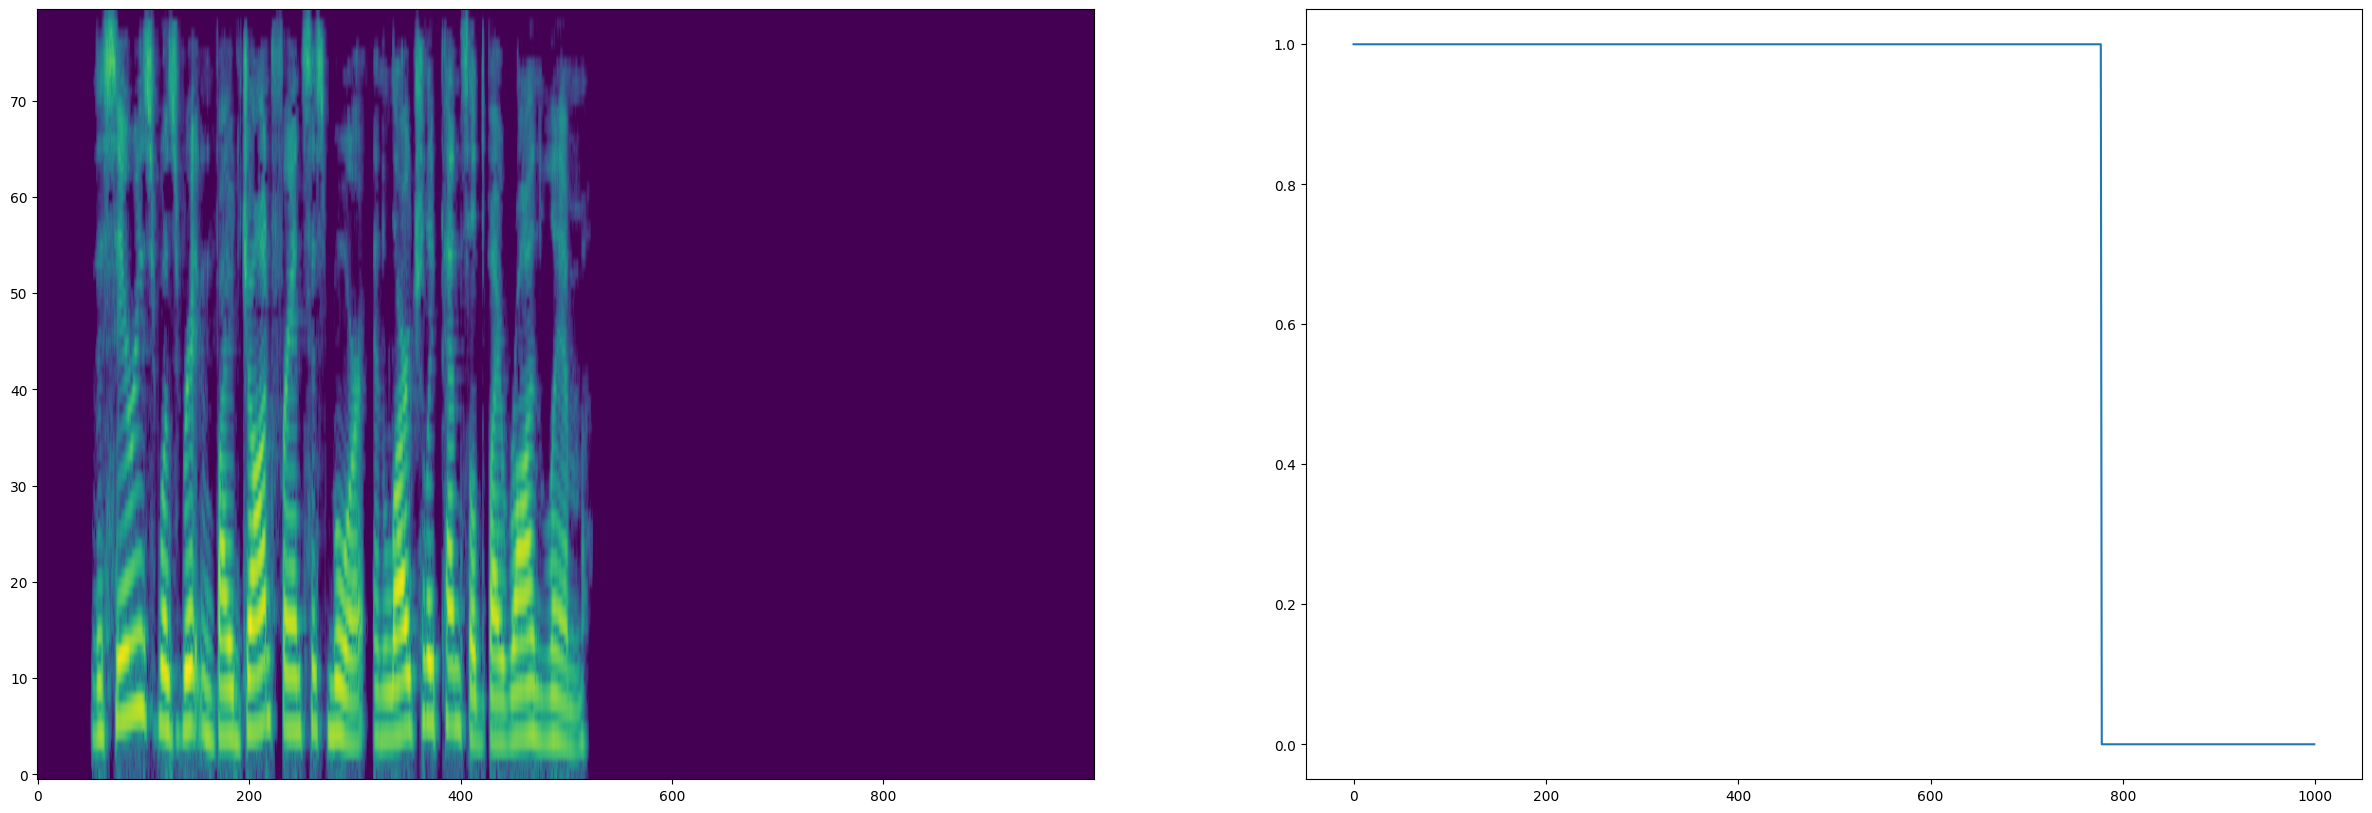

In [22]:
sample_index = 200003

mel_spectogram = zarr_root["features"][sample_index, :]
attention_mask = zarr_root["attention_mask"][sample_index, :]

f, ax = plt.subplots(1, 2, figsize=(30, 10))

ax[0].imshow(mel_spectogram, aspect="auto", origin="lower", cmap="viridis")
ax[1].plot(attention_mask)